
# # Task 1: Preprocess and Explore the Data
# 
# **Objective:** Load, clean, and explore financial time series data to prepare it for modeling.
# 
# Assets: TSLA, BND, SPY  
# Period: Jan 1, 2015 – Jan 15, 2026



In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
import os

sns.set(style="whitegrid")

# Create directory if it doesn't exist
os.makedirs('../data/processed/', exist_ok=True)

# ## 1. Extract Historical Financial Data

In [4]:
assets = ['TSLA', 'BND', 'SPY']
start_date = '2015-01-01'
end_date = '2026-01-15'

raw_data = yf.download(
    assets,
    start=start_date,
    end=end_date,
    auto_adjust=True,
    progress=False
)

# Select Adjusted Close prices
data = raw_data['Close']

print("Data Head:")
display(data.head())

Data Head:


Ticker,BND,SPY,TSLA
Date,,,
2015-01-02,60.385979,170.589630,14.620667
2015-01-05,60.561306,167.508759,14.006000
2015-01-06,60.736656,165.931091,14.085333
2015-01-07,60.773193,167.998749,14.063333
2015-01-08,60.678219,170.979950,14.041333


# ## 2. Data Cleaning and Understanding

In [5]:
print("Data Info:")
data.info()

print("\nBasic Statistics:")
display(data.describe())

print("\nMissing Values:")
print(data.isnull().sum())

# Handle missing values using interpolation (time-series safe)
data = data.interpolate(method='time').fillna(method='bfill')

# Ensure correct data types
data = data.astype(float)

Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2775 entries, 2015-01-02 to 2026-01-14
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BND     2775 non-null   float64
 1   SPY     2775 non-null   float64
 2   TSLA    2775 non-null   float64
dtypes: float64(3)
memory usage: 86.7 KB

Basic Statistics:


Ticker,BND,SPY,TSLA
count,2775.000000,2775.000000,2775.000000
mean,67.325728,339.074725,138.472937
std,4.685295,141.925744,131.682073
min,59.698620,154.980865,9.578000
25%,63.436424,219.599663,17.851666
50%,66.492058,301.538574,91.625999
75%,71.237350,423.938492,242.028336
max,76.068130,695.159973,489.880005



Missing Values:
Ticker
BND     0
SPY     0
TSLA    0
dtype: int64


/var/folders/nf/drxnv59536v7bnknmx3c_1zw0000gn/T/ipykernel_26653/2565706510.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.interpolate(method='time').fillna(method='bfill')


# ## 3. Normalize Data (for ML readiness)

In [6]:
scaler = MinMaxScaler()
normalized_data = pd.DataFrame(
    scaler.fit_transform(data),
    columns=data.columns,
    index=data.index
)


# ## 4. Exploratory Data Analysis (EDA)


# ### 4.1 Price Trends Over Time

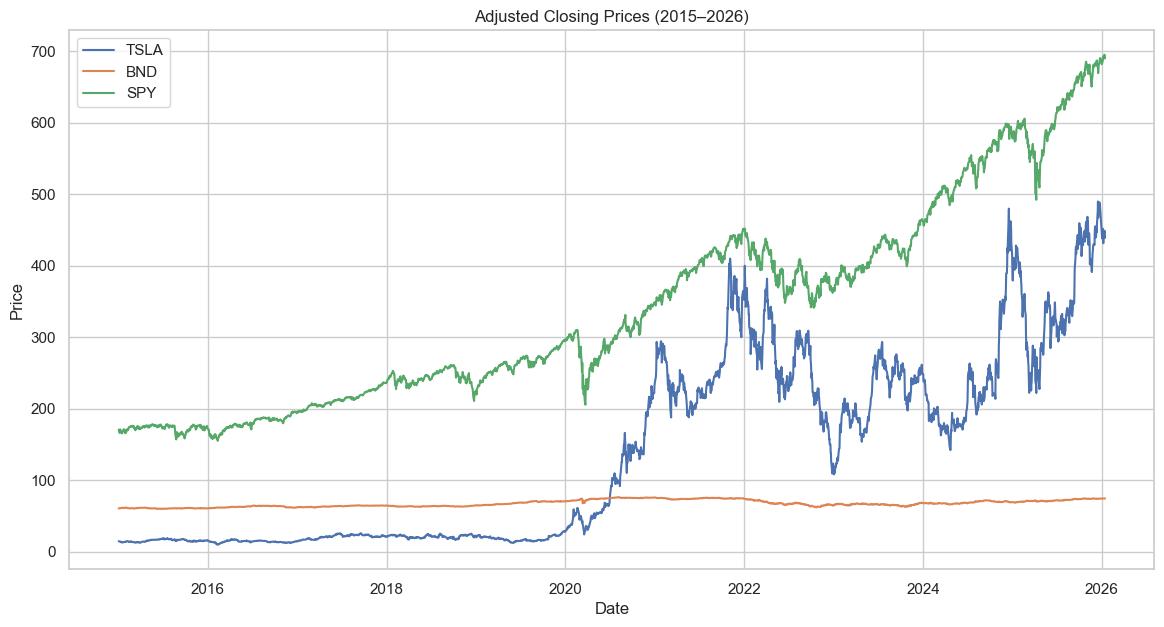

In [7]:
plt.figure(figsize=(14, 7))
for asset in assets:
    plt.plot(data.index, data[asset], label=asset)

plt.title('Adjusted Closing Prices (2015–2026)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# ### 4.2 Daily Returns & Volatility

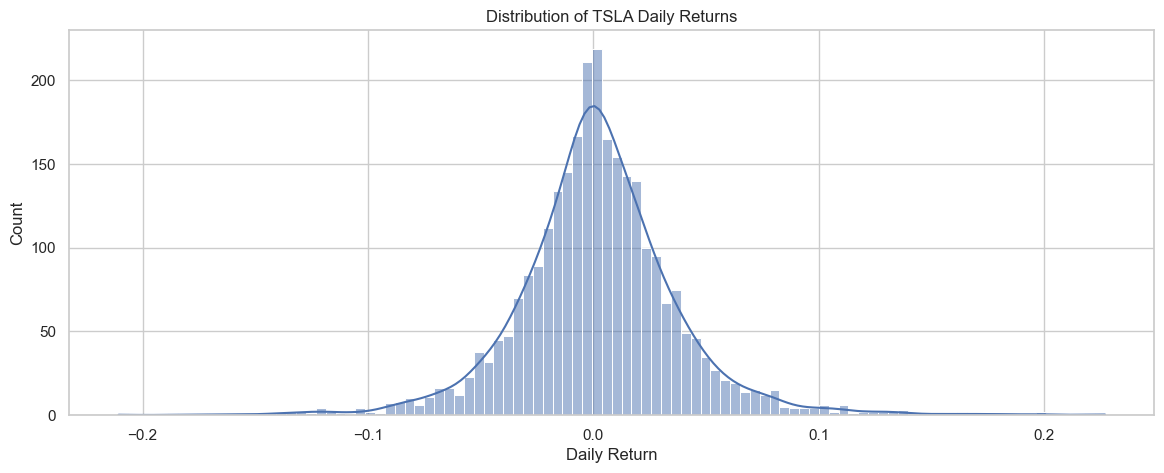

In [8]:
returns = data.pct_change().dropna()

plt.figure(figsize=(14, 5))
sns.histplot(returns['TSLA'], bins=100, kde=True)
plt.title('Distribution of TSLA Daily Returns')
plt.xlabel('Daily Return')
plt.show()

# ### 4.3 Rolling Volatility Analysis

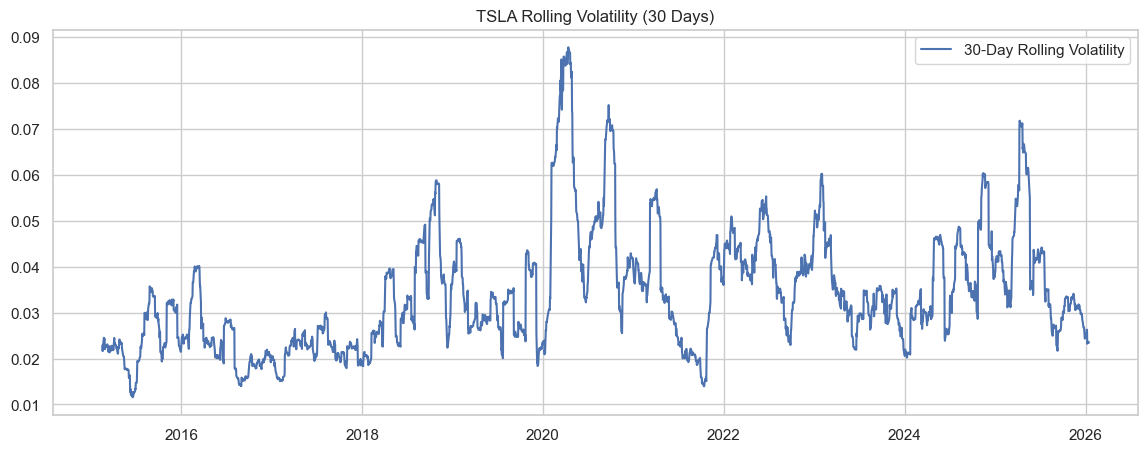

In [9]:
rolling_mean = returns['TSLA'].rolling(window=30).mean()
rolling_std = returns['TSLA'].rolling(window=30).std()

plt.figure(figsize=(14, 5))
plt.plot(rolling_std, label='30-Day Rolling Volatility')
plt.title('TSLA Rolling Volatility (30 Days)')
plt.legend()
plt.show()

# ## 5. Outlier Detection (Extreme Returns)

Number of extreme return days (|z| > 3):
Ticker
BND     32
SPY     39
TSLA    44
dtype: int64


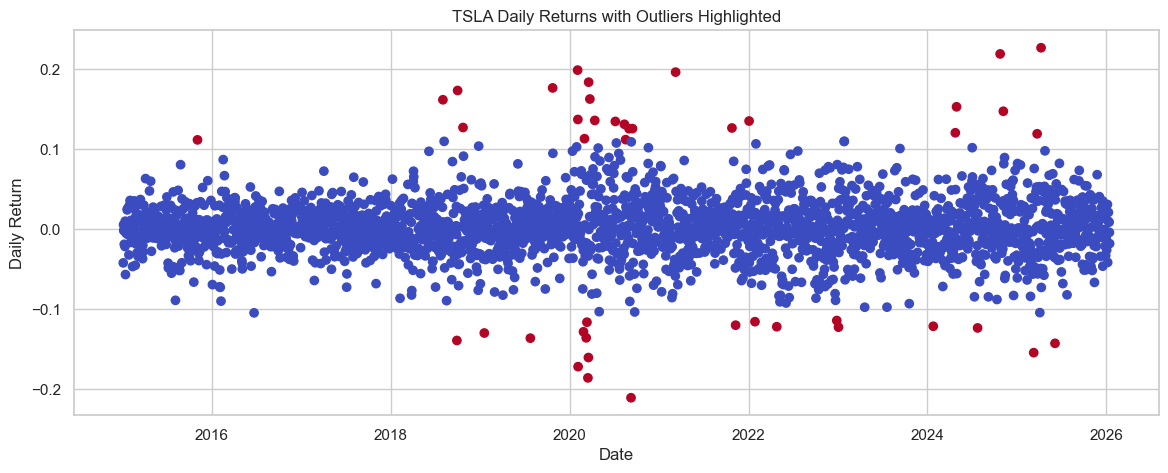

In [10]:
z_scores = (returns - returns.mean()) / returns.std()
outliers = z_scores[np.abs(z_scores) > 3]

print("Number of extreme return days (|z| > 3):")
print(outliers.count())

# Visualize outliers
plt.figure(figsize=(14, 5))
plt.scatter(
    returns.index,
    returns['TSLA'],
    c=(np.abs(z_scores['TSLA']) > 3),
    cmap='coolwarm',
    label='Outliers'
)
plt.title('TSLA Daily Returns with Outliers Highlighted')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.show()

# ## 6. Stationarity Test (ADF Test)

In [11]:
def adf_test(series, name):
    result = adfuller(series)
    print(f"\nADF Test for {name}")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    if result[1] <= 0.05:
        print("Result: Stationary (Reject H0)")
    else:
        print("Result: Non-Stationary (Fail to Reject H0)")

adf_test(data['TSLA'], "TSLA Prices")
adf_test(returns['TSLA'], "TSLA Returns")


ADF Test for TSLA Prices
ADF Statistic: -0.7802
p-value: 0.8249
Result: Non-Stationary (Fail to Reject H0)

ADF Test for TSLA Returns
ADF Statistic: -53.0196
p-value: 0.0000
Result: Stationary (Reject H0)


# ### 7. Risk Metrics

In [12]:
var_95 = returns.quantile(0.05)

print("Value at Risk (95%):")
display(var_95)

# Annualized Sharpe Ratio (Risk-free rate = 0)
sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(252)

print("Annualized Sharpe Ratio:")
display(sharpe_ratio)


Value at Risk (95%):


Ticker
BND    -0.004796
SPY    -0.016719
TSLA   -0.052529
Name: 0.05, dtype: float64

Annualized Sharpe Ratio:


Ticker
BND     0.381458
SPY     0.803992
TSLA    0.823185
dtype: float64

# ## 8. Save Processed Data

In [13]:
data.to_csv('../data/processed/cleaned_prices.csv')
returns.to_csv('../data/processed/daily_returns.csv')
normalized_data.to_csv('../data/processed/normalized_prices.csv')

print("Processed datasets saved successfully.")

Processed datasets saved successfully.
